In [13]:
# Basic
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
import pickle

# GLM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import family
from statsmodels.stats.multitest import multipletests
 
# Modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, StackingRegressor, StackingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from mlxtend.regressor import StackingCVRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score

# Mertrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, precision_score, roc_curve, recall_score, precision_recall_curve, precision_recall_fscore_support, roc_auc_score, ConfusionMatrixDisplay, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint

# oversampling method by SMOTE 
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

# import graphviz
%matplotlib inline

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# glance wd
os.getcwd()

'/home/jhou2/HSV434/LandscapeProject/HSV434-IFNG-mechanism'

In [14]:
os.chdir('/home/jhou2/HSV434/LandscapeProject/HSV434-IFNG-mechanism')

## Over-sampling (Increase Minority Class, IFNG+)

### PCA check data distribution by IFNG_bin
#### Previously, by using SMOTE not address the issue we saw from using original data, even worse the precision result, not improve recall. 
#### By checking IFNG distribution in PCA, should be helpful to understand the Borderline case, suggesting use BorderlineSMOTE

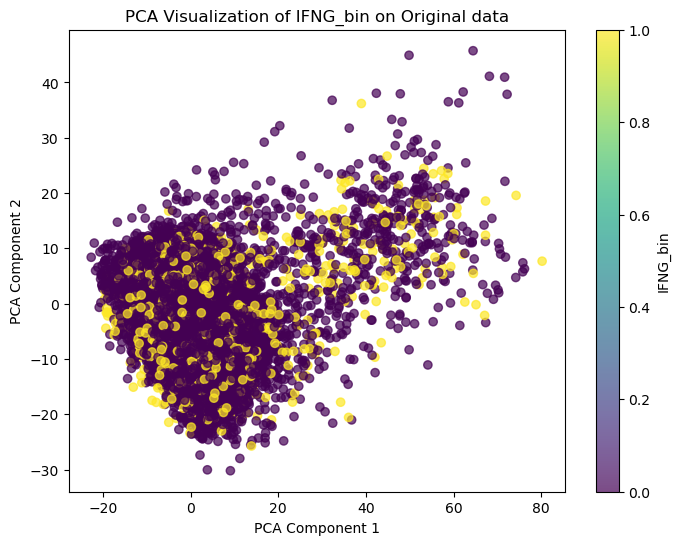

In [6]:
# By using original data 
# Separate features and target
exp_matrix_Original = load('Processed/HSV434_Tcell_IFNG_mechanism_exp_matrix')
X = exp_matrix_Original.drop(['Subject', 'Status', 'CellType_Level3', 'IFNG_bin'], axis = 1)
y = exp_matrix_Original['IFNG_bin']

# Scale the data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(scaled_X)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='IFNG_bin')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of IFNG_bin on Original data')
plt.show()

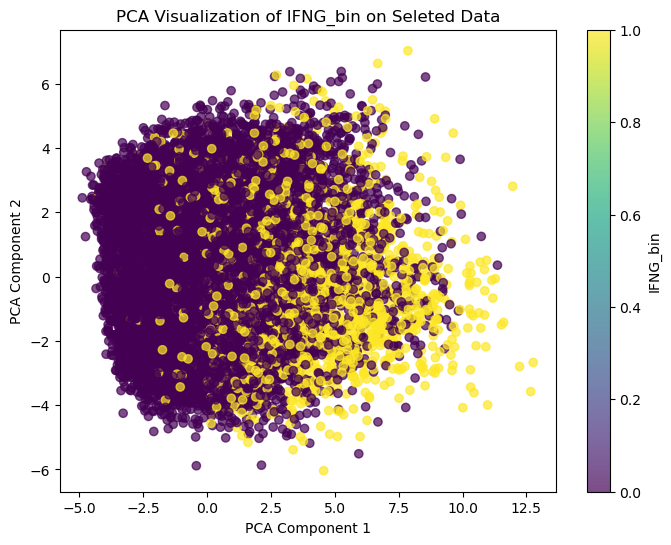

In [10]:
# By using selected gene data
# Separate features and target
selected_significant_genes = load('Processed/HSV434_Tcell_IFNG_mechanism_ML_Original_significant_genes')
# Select data based on significant_genes
if 'IFNG' not in selected_significant_genes['Gene']:
    gene_names = selected_significant_genes['Gene'].tolist()
    # assume CellType and Status may play roles here
    columns_to_select = ['CellType_Level3', 'Status', 'IFNG_bin']
    columns_to_select.extend(gene_names)

exp_matrix_Original_select = exp_matrix_Original[columns_to_select]
exp_matrix_Original_select.head(3)

X = exp_matrix_Original_select.drop(['Status', 'CellType_Level3', 'IFNG_bin'], axis=1)
y = exp_matrix_Original_select['IFNG_bin']

# Scale the data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(scaled_X)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='IFNG_bin')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of IFNG_bin on Seleted Data')
plt.show()

In [27]:
# Since SMOTE should be only working on training sample, not testing samples, 
# we should split data first prior to applying SMOTE

In [28]:
# Cell Type is nominal variable --> one-hot encoding
# dummies_CellType = pd.get_dummies(exp_meta_df.CellType_Level3)
# dummies_CellType = dummies_CellType.astype(int)
# exp_meta_df = pd.concat([exp_meta_df, dummies_CellType], axis='columns')
# exp_meta_df.head(2)

# DO NOT remove Cell Type column, need this in SOMTE
# exp_meta_df = pd.concat([exp_meta_df.drop('CellType_Level3', axis=1), dummies_CellType], axis='columns')
# exp_meta_df.head(2)

In [29]:
# Status is Ordinal variable with inherent order --> Ordinal encoding
# exp_meta_df['Status'].replace(['Prior', 'Lesion', 'Post'], [0, 1, 2], inplace=True)
# exp_meta_df.head(2)

# DO NOT include Status variable as
# (1) previous model indicates Status maybe not contribute much to the model
# (2) if group by celltype + status and split them by IFN_bin, some groups insufficient samples for SOMTE

# pd.set_option('display.max_rows', 100)
# exp_meta_df.groupby(['CellType_Level3', 'Status', 'IFNG_bin']).size()

In [15]:
exp_meta_df = load('Processed/HSV434_Tcell_IFNG_mechanism_exp_matrix')

In [16]:
# Split the data into training and testing sets first
X = exp_meta_df.drop(columns=['Subject', 'IFNG_bin', 'Status'])  # Features
y = exp_meta_df['IFNG_bin']  # Target variable
# Perform a stratified split to maintain the class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [33]:
# SMOTE requires at least n_neighbors + 1 samples in a group to generate synthetic samples. 
# By default, SMOTE uses n_neighbors=5, meaning that each group needs at least 6 samples
# group_counts = X_train.groupby(['CellType_Level3', 'Status']).size()
# print(group_counts[group_counts < 6])

In [17]:
# Initialize an empty list to store the resampled DataFrames
exp_matrix_OverSampling = []

# Loop over each unique CellType_Level3
for cluster in X_train['CellType_Level3'].unique():
    # Subset the data for the current cell type
    cluster_data = X_train[X_train['CellType_Level3'] == cluster]
    y_cluster = y_train[cluster_data.index]  # Get corresponding target values for this subset

    # Check class distribution for IFNG+ (1) and IFNG- (0)
    class_counts = y_cluster.value_counts()
    min_class_count = class_counts.min() if len(class_counts) == 2 else 0

    if min_class_count < 6:
        print(f"Skipping {cluster} due to insufficient samples in one or more classes.")
        continue
    
    # Apply SMOTE only to the current cluster's data (balancing IFNG+ and IFNG- cells)
    smote = BorderlineSMOTE(random_state=42)
    X_cluster_resampled, y_cluster_resampled = smote.fit_resample(
        cluster_data.drop(columns=['CellType_Level3']), y_cluster
    )
    
    # Reattach the CellType_Level3 column for future use
    X_cluster_resampled['CellType_Level3'] = cluster
    
    # Concatenate the resampled data for this cluster
    resampled_cluster_data = pd.concat([X_cluster_resampled, 
                                        pd.Series(y_cluster_resampled, name='IFNG_bin')], axis=1)
    
    # Append the resampled cluster data to the list
    exp_matrix_OverSampling.append(resampled_cluster_data)

In [18]:
# Concatenate all resampled subgroups into one DataFrame
exp_matrix_OverSampling = pd.concat(exp_matrix_OverSampling, ignore_index=True)

In [19]:
exp_matrix_OverSampling.head(5)

,MIR1302_2HG,AL627309_1,AL627309_3,AL669831_5,FAM87B,LINC00115,FAM41C,AL645608_7,SAMD11,NOC2L,...,HSV1_UL36,HSV2_UL18,HSV2_UL23,HSV2_UL26,HSV2_UL47,HSV2_UL49,HSV2_UL50,HSV2_US9,CellType_Level3,IFNG_bin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.159451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD4 TRM,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD4 TRM,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD4 TRM,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD4 TRM,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD4 TRM,0


In [20]:
# Validate the resampled data
print(f"Shape of resampled data: {exp_matrix_OverSampling.shape}")
print(f"Missing values:\n{exp_matrix_OverSampling.isnull().sum()}")
print(f"Duplicate rows: {exp_matrix_OverSampling.duplicated().sum()}")

Shape of resampled data: (22924, 24955)
Missing values:
MIR1302_2HG        0
AL627309_1         0
AL627309_3         0
AL669831_5         0
FAM87B             0
                  ..
HSV2_UL49          0
HSV2_UL50          0
HSV2_US9           0
CellType_Level3    0
IFNG_bin           0
Length: 24955, dtype: int64
Duplicate rows: 0


In [21]:
# Confirm that all required columns are present
required_columns = X.columns.tolist() + ['CellType_Level3', 'IFNG_bin']
missing_columns = set(required_columns) - set(exp_matrix_OverSampling.columns)
if missing_columns:
    print(f"Warning: Missing columns in resampled data: {missing_columns}")
    
# Check the class distribution per CellType_Level3 and Status after SMOTE
print(pd.crosstab(exp_matrix_OverSampling['CellType_Level3'], 
                  exp_matrix_OverSampling['IFNG_bin']))

IFNG_bin            0     1
CellType_Level3            
CD4 Act           390   390
CD4 CM           1016  1016
CD4 EM 1         1446  1446
CD4 EM 2         1400  1400
CD4 EM 3          932   932
CD4 ISG           607   607
CD4 Prolif        456   456
CD4 TRM           574   574
CD8 CM           1246  1246
CD8 EM 1         1107  1107
CD8 EM 2          869   869
CD8 ISG           233   233
CD8 TRM 1         274   274
CD8 TRM 2         912   912


### Feature selection

### (1) Filter out features/variables based on presence % across samples. By using 10% cutoff (remove if expressed in fewer than 10% samples), narrow down from 24955 to 6908

In [21]:
# same columns are totally 0 as we select some clusters not all clusters (like, no Treg et.al)
# exp_matrix_OverSampling.columns[(exp_matrix_OverSampling == 0).all()].tolist()
# print("how many columns total empty:",len(exp_matrix_OverSampling.columns[(exp_matrix_OverSampling == 0).all()]))

In [22]:
# Identify columns that are not entirely 0
# columns_not_entirely_zero = exp_matrix_OverSampling.columns[(exp_matrix_OverSampling != 0).any()]
# Select only the columns that are not entirely 0
# exp_matrix_OverSampling = exp_matrix_OverSampling[columns_not_entirely_zero]

In [22]:
# remove features expressed in fewer than 10% of samples
threshold = 0.1  # Feature must be non-zero in at least 10% of samples
exp_matrix_OverSampling_filter = exp_matrix_OverSampling.loc[:, (exp_matrix_OverSampling != 0).mean() > threshold]
print("Shape before applying threshold:", exp_matrix_OverSampling.shape)
print("Shape after applying threshold:", exp_matrix_OverSampling_filter.shape)

Shape before applying threshold: (22924, 24955)
Shape after applying threshold: (22924, 6908)


In [23]:
# save files
with open('Processed/HSV434_Tcell_IFNG_mechanism_ML_OverSampling_data.pickle', 'wb') as file:
    pickle.dump((X_train, X_test, y_train, y_test, exp_matrix_OverSampling, exp_matrix_OverSampling_filter), file)

In [24]:
# scaling 
exp_matrix_OverSampling_filter_scale = exp_matrix_OverSampling_filter.copy()
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
columns_to_scale = exp_matrix_OverSampling_filter_scale.columns.difference(['CellType_Level3', 'IFNG_bin'])
exp_matrix_OverSampling_filter_scale[columns_to_scale] = scaler.fit_transform(exp_matrix_OverSampling_filter_scale[columns_to_scale])
exp_matrix_OverSampling_filter_scale.head(2)

,NOC2L,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,INTS11,CPTP,AURKAIP1,...,ITGB2_AS1,FAM207A,ADARB1,MCM3AP,YBEY,PCNT,DIP2A,PRMT2,CellType_Level3,IFNG_bin
0,1.772510,0.423560,-0.762309,1.226203,-0.857516,-0.355056,-0.501721,-0.612907,-0.296134,-0.834042,...,-0.478942,-0.341313,-0.409350,2.587887,-0.282589,-0.344598,-0.481072,0.381195,CD4 TRM,0
1,-0.503659,0.262941,1.404784,0.445760,-0.857516,-0.355056,1.414718,1.012674,2.665943,0.541609,...,-0.478942,-0.341313,1.758913,-0.347680,-0.282589,-0.344598,-0.481072,-0.996537,CD4 TRM,0


### (2) Apply GLM model (within QuasiPoisson Distribution to model most significant genes associated with IFN_bin) further narrow down gene variables from 6908 to 3487, but still too many for building model

In [25]:
# Initialize list to store results
results = []

# Identify gene columns (excluding non-gene columns like 'CellType_Level3')
gene_columns = [col for col in exp_matrix_OverSampling_filter_scale.columns if (col not in ['CellType_Level3'])]

# Iterate over each gene to fit a quasi-Poisson model or try sm.families.Binomial
for gene in gene_columns:
    formula = f'IFNG_bin ~ {gene}' # + CellType_Fine + Status

    # Fit GLM with Binomial family
    model = smf.glm(formula = formula, data = exp_matrix_OverSampling_filter_scale, family = sm.families.Binomial()).fit()

    # Extract p-value for the gene
    p_value = model.pvalues[1]  # Get the p-value for 'IFNGbin'

    # Append results
    results.append((gene, p_value))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Gene', 'P_value'])

# Adjusting p-values for multiple testing, for example using Bonferroni correction
rejected, corrected_p_values, _, _ = multipletests(results_df['P_value'], method='bonferroni')

# Adding corrected p-values to the results DataFrame
results_df['Corrected_P_value'] = corrected_p_values

/home/jhou2/.local/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/jhou2/.local/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/jhou2/.local/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/jhou2/.local/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, cat

In [26]:
# Identifying significant genes
significant_genes = results_df[results_df['Corrected_P_value'] < 0.01]
significant_genes

,Gene,P_value,Corrected_P_value
0,NOC2L,7.183126e-26,4.961385e-22
1,ISG15,2.440217e-14,1.685458e-10
2,TNFRSF18,7.362693e-72,5.085412e-68
3,TNFRSF4,1.502174e-55,1.037552e-51
4,SDF4,8.806744e-11,6.082818e-07
...,...,...,...
6891,TRAPPC10,2.358773e-11,1.629204e-07
6893,C21orf2,9.126719e-30,6.303825e-26
6897,ITGB2,3.016688e-28,2.083627e-24
6898,ITGB2_AS1,2.564015e-09,1.770965e-05


### (3) Lasso model by using L1 penalty on these 3487 variables to narrow down further, about 225 genes for final model 

In [27]:
# Prepare your data (excluding the target 'IFNG_bin' and any categorical columns like 'CellType_Level3')
X = exp_matrix_OverSampling_filter_scale.drop(columns=['IFNG_bin', 'CellType_Level3'])
y = exp_matrix_OverSampling_filter_scale['IFNG_bin']

# Subset the data to only include selected genes (from p-value filtering or feature importance)
significant_gene_list = significant_genes['Gene'].tolist()  # Extract the list of genes
X = X[significant_gene_list]

In [28]:
# Step 1: Apply LogisticRegressionCV with L1 regularization and cross-validation to find the best C
lasso_cv = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=10000, cv=5)
lasso_cv.fit(X, y)

# Step 2: Retrieve the best C parameter from cross-validation
best_C = lasso_cv.C_
print(f"Best C parameter: {best_C}")
# Best C parameter: [0.04641589]

Best C parameter: [0.00599484]


In [29]:
# Step 3: Retrain the model using the best C
lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=float(best_C))
lasso.fit(X, y)

/loc/scratch/6977481/ipykernel_28576/1868559734.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=float(best_C))


LogisticRegression(C=0.005994842503189409, max_iter=10000, penalty='l1',
                   solver='saga')

In [43]:
# Step 4: Extract the coefficients and create a DataFrame of features with their coefficients
coefficients = lasso.coef_[0]
feature_importance = pd.DataFrame({
    'Gene': X.columns,
    'Coefficient': coefficients
})

# Step 5: Select genes with non-zero coefficients
selected_genes = feature_importance[feature_importance['Coefficient'] != 0]

# Step 6: Sort the selected genes by the absolute value of their coefficients
selected_genes = selected_genes.sort_values(by='Coefficient', key=abs, ascending=False)

# Display the selected genes
print(selected_genes)

        Gene  Coefficient
2860    CCL5     0.243939
2861    CCL4     0.159304
2166    CD69     0.147752
596    CTLA4     0.135857
150      JUN     0.133773
...      ...          ...
788     HLTF    -0.000251
592    CFLAR     0.000207
1687     AK3     0.000110
1143  RIPOR2     0.000021
1259   ARMC2     0.000007

[739 rows x 2 columns]


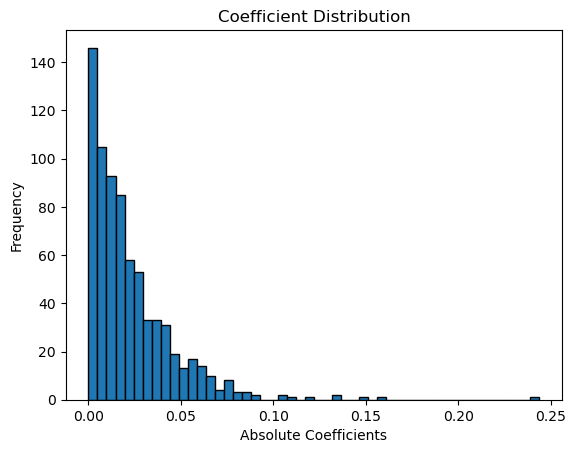

In [44]:
# Plot the distribution of absolute coefficients
plt.hist(np.abs(selected_genes['Coefficient']), bins=50, edgecolor='k')
plt.xlabel('Absolute Coefficients')
plt.ylabel('Frequency')
plt.title('Coefficient Distribution')
plt.show()

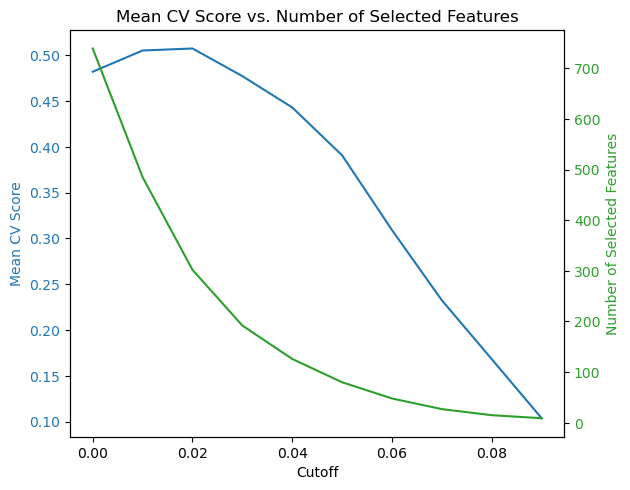

In [49]:
# Select proper coefficient to get rid of some noise

# List of cutoff values to test
cutoffs = np.arange(0, 0.1, 0.01)  # From 0 to 1 with step of 0.01
mean_cvs = []
num_selected_features = []

# Iterate through each cutoff value
for cutoff in cutoffs:
    # Step 1: Select genes with non-zero coefficients above the cutoff
    selected_genes_filter = selected_genes[selected_genes['Coefficient'].abs() > cutoff]
    selected_genes_filter = selected_genes_filter.sort_values(by='Coefficient', key=abs, ascending=False)
    
    # Step 2: Select corresponding features from X
    X_selected = X[selected_genes_filter['Gene'].tolist()]
    
    # Step 3: Train the Lasso model
    lasso_cv = LassoCV(cv=5).fit(X_selected, y)
    
    # Step 4: Evaluate performance with cross-validation
    scores = cross_val_score(lasso_cv, X_selected, y, cv=5)
    
    # Store the Mean CV score and number of selected features
    mean_cvs.append(np.mean(scores))
    num_selected_features.append(len(selected_genes_filter))

# Plotting Mean CV score vs. Number of selected features
fig, ax1 = plt.subplots()

# Plot Mean CV score
ax1.set_xlabel('Cutoff')
ax1.set_ylabel('Mean CV Score', color='tab:blue')
ax1.plot(cutoffs, mean_cvs, color='tab:blue', label='Mean CV Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot the number of selected features
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Selected Features', color='tab:green')
ax2.plot(cutoffs, num_selected_features, color='tab:green', label='Number of Selected Features')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()  # To ensure the labels do not overlap
plt.title('Mean CV Score vs. Number of Selected Features')
plt.show()

In [51]:
# Set an absolute coefficient cutoff
cutoff = 0.02 # better performance, reasonable features, higher CV score

# Step 5: Select genes with non-zero coefficients
selected_genes_final = selected_genes[selected_genes['Coefficient'] > cutoff].sort_values(by='Coefficient', key=abs, ascending=False)

# Number of genes selected
selected_genes_final

,Gene,Coefficient
2860,CCL5,0.243939
2861,CCL4,0.159304
2166,CD69,0.147752
596,CTLA4,0.135857
150,JUN,0.133773
...,...,...
1589,CTSB,0.020405
1781,ZDHHC12,0.020244
1810,PAXX,0.020231
1703,BAG1,0.020231


In [52]:
# save significant_genes
selected_genes_final.to_csv('Results/OverSampling_significant_genes.csv')
dump(selected_genes_final, 'Processed/HSV434_Tcell_IFNG_mechanism_ML_OverSampling_significant_genes')
dump(selected_genes, 'Processed/HSV434_Tcell_IFNG_mechanism_ML_OverSampling_significant_genes_preFilter')

['Processed/HSV434_Tcell_IFNG_mechanism_ML_OverSampling_significant_genes_preFilter']